# <font color='blue'>Introduction to Sparsity</font>

---

<img src="images/cea_logo.png" width="100" align="right">


> Author: **Samuel Farrens**

> Year: **2016**

> Version: **1.0**

> Email: **[samuel.farrens@cea.fr](mailto:samuel.farrens@cea.fr)**

> Web: **[CosmoStat Website](http://www.cosmostat.org/)**


## <font color='blue'>Contents</font>

---
 
1. [Set-Up](#Set-Up)
1. [Introduction](#Introduction)
1. [Time-Frequency Example](#Time-Frequency-Example)
1. [Sparsity](#Sparsity)
 * [Sparse Representation](#Sparse-Representation)
 * [Measures of Sparsity](#Measures-of-Sparsity)
 * [Promoting Sparsity](#Promoting-Sparsity)
1. [Denoising Exercise](#Denoising-Exercise)
1. [Inpainting Exercise](#Inpainting-Exercise)
1. [Hints](#Hints)

## <font color='blue'>Set-Up</font>

---

Here we will import a couple of packages that we will need throughout the notebook.

In [51]:
# Tell Jupyter to display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np           

# Import the pyplot package from matplotlib with the alias plt.
import matplotlib.pyplot as plt  
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Import some tools from scipy.
from scipy import fftpack

# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

# SOME USEFUL FUNCTIONS

# Function to calculate an orthonormal discrete cosine transform.
def fft(signal):

    return fftpack.fft(signal)

# Function to calculate an orthonormal discrete cosine transform.
def ifft(signal):

    return fftpack.ifft(signal)

# Function to calculate an orthonormal discrete cosine transform.
def dct(signal):

    return fftpack.dct(signal, norm='ortho')

# Function to calculate an orthonormal discrete cosine transform.
def idct(signal):

    return fftpack.idct(signal, norm='ortho')

# Function to calculate the median absolute deviation.
def sigma_mad(signal):
    
    return 1.4826 * np.median(np.abs(signal - np.median(signal)))

## <font color='blue'>Introduction</font>

---

A sparse signal is one that is comprised mostly of zeros when expressed in the appropriate basis.

## <font color='blue'>Time-Frequency Example</font>

---

Let's start with a simple sine wave example. We have a time series signal where

$$y = \sin(t)$$

with a sampling rate of 30 and a frequency of 2. We can display this function as follows:

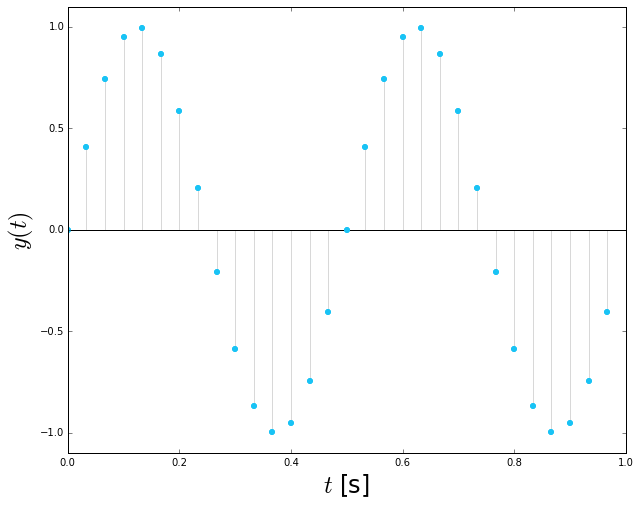

In [52]:
# Set the signal properties.
sampling_rate = 30.0
frequency = 2

# Set a range of t values.
t = np.arange(0, 1, 1.0 / sampling_rate)

# Get the corresponding y values.
y = np.sin(2 * np.pi * frequency * t)

# Display
plt.plot((t, t), (np.zeros(y.size), y), '-', color='#D8D8D8')
plt.plot((0.0, 1.0), (0.0, 0.0), 'k-')
plt.plot(t, y, 'o', color='#19C3F5', markeredgewidth=0.0)
plt.xlabel('$t$ [s]', fontsize=24)
plt.ylabel('$y(t)$', fontsize=24)
plt.ylim(-1.1, 1.1)
plt.show()

We can clearly see that the signal is not sparse as the majority of coefficients are non-zero and hence it is not sparse in this representation. However, if we examine the frequency component of this signal it becomes very sparse indeed.

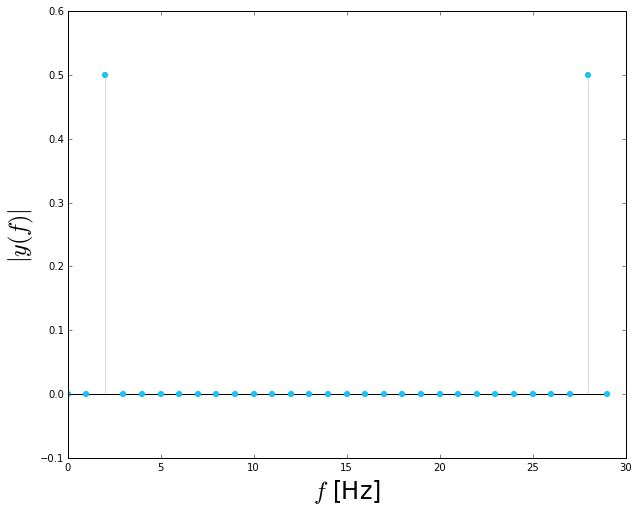

In [54]:
# Get the one-sided frequency range.
f = np.arange(y.size) * sampling_rate / y.size 
# f = f[:y.size / 2]

# Calculate the normalised FFT of the signal.
y_fft = np.abs(np.fft.fft(y)) / y.size 
# y_fft = y_fft[:y.size / 2]

# Display
plt.plot((f, f), (np.zeros(y_fft.size), y_fft), '-', color='#D8D8D8')
plt.plot((0.0, max(f)), (0.0, 0.0), 'k-')
plt.plot(f, y_fft, 'o', color='#19C3F5', markeredgewidth=0.0)
plt.xlabel('$f$ [Hz]', fontsize=24)
plt.ylabel('$|y(f)|$', fontsize=24)
plt.ylim(-0.1, 0.6)
plt.show()

Now, we have only a single coefficient which is non-zero. So, although in its natural domain our signal does not appear to be sparse we were able to find a sparse representation in a different basis.

So, how can the knowledge that a given signal is sparse in a given domain be useful?

## <font color='blue'>Sparsity</font>

---

We can use the knowledge that a signal is sparse in a given domain as prior knowledge when solving an inverse problem. This enables us to reduce the parameters space and allows us to converge upon a better and simpler solution.



### <font color='green'>Sparse Representation</font>

A signal $x$ can be respresented as

$$x = \phi\alpha = \sum_{i=1}^n\phi_i\alpha_i$$

where $\alpha$ are the sparse coefficients of $x$ in the dictionary $\phi$ and $n$ is the sparsity of the signal. Each $\phi_i$ corresponds to an *atom* of the dictionay $\phi$. In the case of Fourier decomposition the atoms are sinusoids and when $\phi$ is a matrix the atoms are the columns of the matrix.

### <font color='green'>Measures of Sparsity</font>

The true sparsity of a signal can be measured with the $l_0$ pseudo-norm.

$$\|x\|_0 = \text{Card}(\text{Supp}(x))$$

*i.e.* the number of non-zero elements in the signal. However, this function is non-convex and is computationally hard  to solve. Therefore, in practice the convex $l_1$ norm is used instead.

$$\|x\|_1 = \sum_{i=1}^n |x_i|$$

The $l_1$ norm is the closest convex norm to $l_0$ and Donoho and Huo 99 have shown that for sufficiently sparse signals the two norms are equivalent.

We can use this to measure the sparsity of our time-frequency example.

In [4]:
# Function to measure the l1 norm.
def l1_norm(signal):
    
    return np.sum(np.abs(signal))

# Get the l1 norm of the time and frequency signals.
print 'The l1 norm of the time signal:', l1_norm(y)
print 'The l1 norm of the frequency signal:', l1_norm(y_fft)

The l1 norm of the time signal: 19.0287289084
The l1 norm of the frequency signal: 0.5


As expected the frequency signal is significantly more sparse.

### <font color='green'>Promoting Sparsity</font>

In order to actually produce solutions that are more sparse one typically performs a thresholding operation in the sparse domain. Standard techniques include hard and soft thresholding.

**Hard Thresholding**

$$HT_{\lambda}(x_i) = \begin{cases} x_i & \text{if}\ |x_i| \geq \lambda \\  0 & \text{otherwise} \\ \end{cases}$$

**Soft Thresholding**

$$ST_{\lambda}(x_i) = \begin{cases} x_i - \lambda\text{sign}(x_i) & \text{if}\ |x_i| \geq \lambda \\  0 & \text{otherwise} \\ \end{cases}$$

The threshold value, $\lambda$, will vary depending on the type of problem. In the case of denoising $\lambda$ represents an estimate of the noise in the sparse domain. 

In [5]:
# Function for performing hard thresholding.
def hard_thresh(signal, threshold):
    
    return signal * (np.abs(signal) >= threshold)

# Function for performing soft thresholding.
def soft_thresh(signal, threshold):
    
    return np.sign(signal) * (np.abs(signal) - threshold) * (np.abs(signal) >= threshold)

# Define a random signal.
np.random.seed(2)
x = np.random.ranf((5, 5))

# Set the threshold.
thresh = 0.6

# Threshold the signal.
x_thresh_hard = hard_thresh(x, thresh)
x_thresh_soft = soft_thresh(x, thresh)

print 'Original Signal.'
print ''
print x
print ''
print 'l1 norm:', l1_norm(x)
print ''
print ''
print 'Hard Thresholded Signal.'
print ''
print x_thresh_hard
print ''
print 'l1 norm:', l1_norm(x_thresh_hard)
print ''
print ''
print 'Soft Thresholded Signal.'
print ''
print x_thresh_soft
print ''
print 'l1 norm:', l1_norm(x_thresh_soft)


Original Signal.

[[ 0.4359949   0.02592623  0.54966248  0.43532239  0.4203678 ]
 [ 0.33033482  0.20464863  0.61927097  0.29965467  0.26682728]
 [ 0.62113383  0.52914209  0.13457995  0.51357812  0.18443987]
 [ 0.78533515  0.85397529  0.49423684  0.84656149  0.07964548]
 [ 0.50524609  0.0652865   0.42812233  0.09653092  0.12715997]]

l1 norm: 9.8529840857


Hard Thresholded Signal.

[[ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.61927097  0.          0.        ]
 [ 0.62113383  0.          0.          0.          0.        ]
 [ 0.78533515  0.85397529  0.          0.84656149  0.        ]
 [ 0.          0.          0.          0.          0.        ]]

l1 norm: 3.72627672493


Soft Thresholded Signal.

[[-0.         -0.         -0.         -0.         -0.        ]
 [-0.         -0.          0.01927097 -0.         -0.        ]
 [ 0.02113383 -0.         -0.         -0.         -0.        ]
 [ 0.18533515  0.25397529 -0.          0.24656149 -0.     

### <font color='green'>Sparse Regularisation</font>

Recall that for solving an inverse problem of the form

$$Y = MX$$

we aimed to minimise a function of the following form

$$\begin{aligned} & \underset{X}{\text{argmin}} & \frac{1}{2}\|Y-MX\|_2^2\end{aligned}$$

Now, if we know that $X$ is sparse in the domain $X = \phi\alpha$ we can update our minimisation problems as follows:

$$\begin{aligned} & \underset{\alpha}{\text{argmin}} & \frac{1}{2}\|Y-M\phi\alpha\|_2^2 + \lambda\|\alpha\|_1\end{aligned}$$

where we now seek a value of $\alpha$ that both minimises the residual and requires that $\alpha$ be sparse. This formulation is generally referred to as a *synthesis prior*. This problem can alternatively be formulated as follows:

$$\begin{aligned} & \underset{X}{\text{argmin}} & \frac{1}{2}\|Y-MX\|_2^2 + \lambda\|\phi^{T}X\|_1\end{aligned}$$

which is referred to as an *analysis prior*. When $\phi$ is orthogonal these two formulations are equivalent, when $\phi$ is not orthogonal this is no longer the case. Each approach has certain benefits when applied to different problems.

## <font color='blue'>Denoising Exercise</font>

---

### Exercise 1

This exercise provides a simple demonstration of how sparse representations of signals can be extremely useful. The objective is to recover the original signal from a noisy observation by denoising it in a sparse domain.

Let's start by looking at the signal, a basic cosine function.

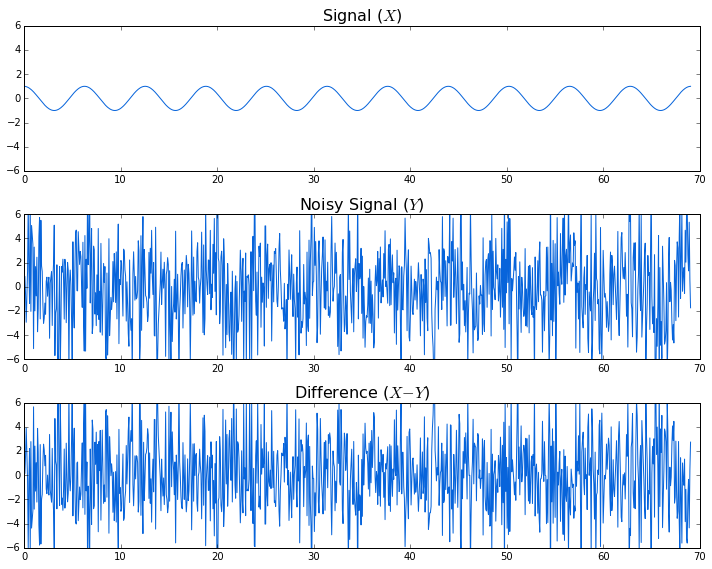

In [22]:
#############################
# NO NEED TO EDIT THIS CELL #
# JUST EXECUTE IT           #
#############################

# Define a range of values
t = np.linspace(0, 22 * np.pi, 1000, endpoint=False)

# Set the noise level.
sigma = 3.0

# Define the signal.
x = np.cos(t + 11 * np.pi / 1000)

# Add noise to the signal.
y = x + sigma * np.random.randn(x.size)

# Display
plt.subplot(311)
plt.plot(t, x, color='#0764DB')
plt.title('Signal ($X$)', fontsize=16)
plt.ylim(-6, 6)
plt.subplot(312)
plt.plot(t, y, color='#0764DB')
plt.title('Noisy Signal ($Y$)', fontsize=16)
plt.ylim(-6, 6)
plt.subplot(313)
plt.plot(t, x - y, color='#0764DB')
plt.title('Difference ($X - Y$)', fontsize=16)
plt.ylim(-6, 6)
plt.tight_layout()
plt.show()

**Choose a sparse domain**

Your first task is to identify an appropriate sparse domain for the signals.
<font color='red'>EDIT THE CELL BELOW</font>

In [23]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# Define the sparse representations of the signals.
# x_sparse = None
# y_sparse = None

# ANSWERS
# x_sparse = fft(x)
# y_sparse = fft(y)
x_sparse = dct(x)
y_sparse = dct(y)

Now we can have a look at the siganls in the sparse domain you used.

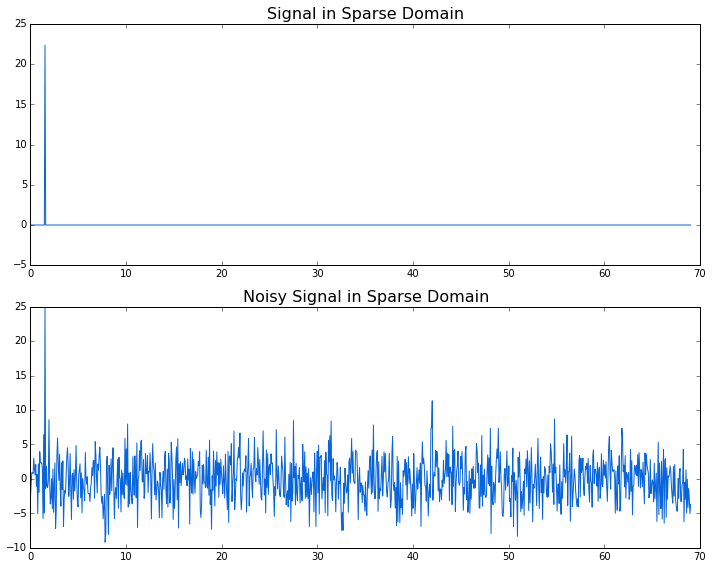

In [24]:
#############################
# NO NEED TO EDIT THIS CELL #
# JUST EXECUTE IT           #
#############################

# Display
if not isinstance(x_sparse, type(None)) and not isinstance(y_sparse, type(None)):
    plt.subplot(211)
    plt.plot(t, x_sparse, color='#0764DB')
    plt.title('Signal in Sparse Domain', fontsize=16)
    plt.subplot(212)
    plt.plot(t, y_sparse, color='#0764DB')
    plt.title('Noisy Signal in Sparse Domain', fontsize=16)
    plt.tight_layout()
    plt.show()

Can you identify and similarities between the original and noisy signals in the sparse domain?

If not, you may want to rethink your choice.

**Denoise the signal**

Your next task is to estimate the noise level of the noisy signal in the sparse domain and remove it.
<font color='red'>EDIT THE CELL BELOW</font>

In [27]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# Estimate the noise in the sparse domain.
# noise_est = None
# print 'Noise Estimate =', noise_est

# Perform hard thresholding.
# x_rec = None

# ANSWERS
noise_est = 4 * sigma_mad(y_sparse) 
# x_rec = ifft(hard_thresh(y_sparse, noise_est))
x_rec = idct(hard_thresh(y_sparse, noise_est))

Now let's look at what you have recovered.

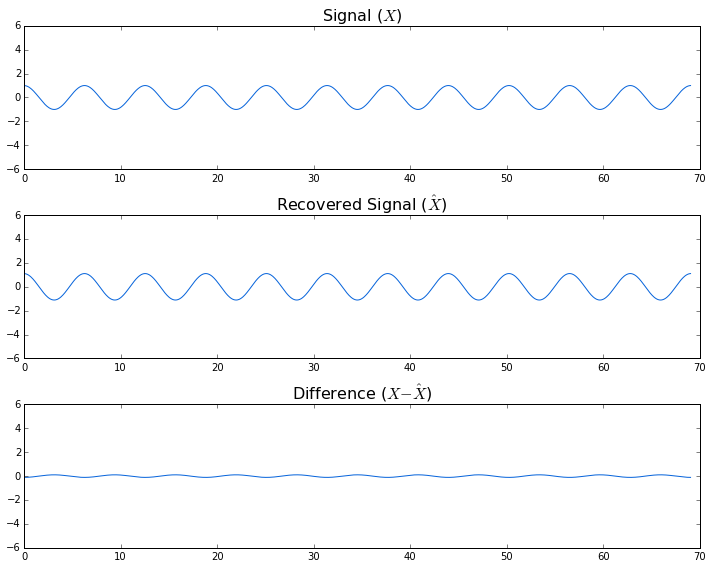

In [28]:
#############################
# NO NEED TO EDIT THIS CELL #
# JUST EXECUTE IT           #
#############################

# Display
if not isinstance(x_rec, type(None)):
    plt.subplot(311)
    plt.plot(t, x, color='#0764DB')
    plt.title('Signal ($X$)', fontsize=16)
    plt.ylim(-6, 6)
    plt.subplot(312)
    plt.plot(t, x_rec, color='#0764DB')
    plt.title('Recovered Signal ($\hat{X}$)', fontsize=16)
    plt.ylim(-6, 6)
    plt.subplot(313)
    plt.plot(t, x - x_rec, color='#0764DB')
    plt.title('Difference ($X-\hat{X}$)', fontsize=16)
    plt.ylim(-6, 6)
    plt.tight_layout()
    plt.show()

Did it work? 

If you signal is still a bit noisy try increasing the noise threshold by a factor *e.g.* $n = 3$ or $n = 4$.

## <font color='blue'>Inpainting Exercise</font>

---

For this exercise you will have to implement sparse regularisation to recover a signal that has been masked and contains additive noise. The application is still very simplistic but the approach is similar what one would need to do with real data.

To complete this exercise you will need to solve the following inverse problem:

$$Y = MX + N$$

where $Y$ is the observed masked signal with noise, $X$ is the signal to be recovered, $M$ is the masking operation and $N$ is the noise content.

Note that the masked signal is smaller than the original and therefore the transpose operation, $M^T$, corresponds to an upsampling.

We will begin the exercise by defining $M$, $M^T$ and the signal. We will also use the descrete cosine tranform as the sparse representation of the signal.

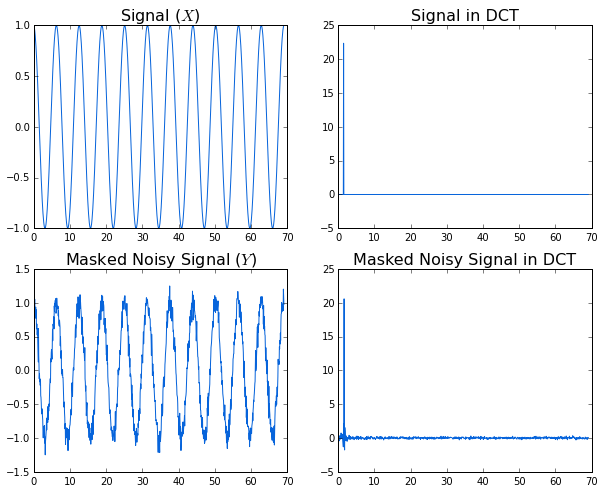

In [48]:
#############################
# NO NEED TO EDIT THIS CELL #
# JUST EXECUTE IT           #
#############################

# Function to mask a signal.
def mask_op(signal, mask):
    
    return signal[np.where(mask == 1)[0]]

# Function to upsample a signal.
def upsample(signal, mask):
    
    val = np.copy(mask)
    val[val == 1] *= signal
    return val

# Set the noise level.
sigma = 0.1

# Set the fraction of masked coefficients.
fraction = 0.1

# Set a range of points.
t = np.linspace(0, 22 * np.pi, 1000, endpoint=False)

# Create a random mask.
np.random.seed(1)
index = np.random.permutation(np.arange(t.size))[:fraction * t.size]
mask = np.ones(t.size)
mask[index] = 0
t_mask = mask_op(t, mask)

# Define the signal.
x = np.cos(t + 11 * np.pi / 1000)
x_dct = dct(x)

# Mask the signal and add Gaussian noise.
y_mask = mask_op(x, mask)
y = y_mask + sigma * np.random.randn(y_mask.size)
y_dct = dct(y)

# Display
plt.subplot(221)
plt.plot(t, x, color='#0764DB')
plt.title('Signal ($X$)', fontsize=16)
plt.subplot(222)
plt.plot(t, x_dct, color='#0764DB')
plt.title('Signal in DCT', fontsize=16)
plt.subplot(223)
plt.plot(t_mask, y, color='#0764DB')
plt.title('Masked Noisy Signal ($Y$)', fontsize=16)
plt.subplot(224)
plt.plot(t_mask, y_dct, color='#0764DB')
plt.title('Masked Noisy Signal in DCT', fontsize=16)
plt.show()

To solve our inverse problem we will use the following minimisation:

$$\begin{aligned} & \underset{\alpha}{\text{argmin}} & \frac{1}{2}\|Y-M\phi\alpha\|_2^2 + \lambda\|\alpha\|_1\end{aligned}$$

where $\alpha$ is the sparse representation of the signal and $\phi$ is the DCT (hence $\phi^{-1}$ is the IDCT). 

We will need to solve this problem iteratively. Recall that we used gradient descent to solve problems of this type before.  

**Define the gradient**

Your first taks is to define a function that calculates the following gradient:

$$\nabla F(\alpha) = \phi^{-1}M^T(M\phi\alpha-Y)$$

> See the [Hints](#Hints) if you get stuck.

In [31]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# Function to calculate the gradient.
def grad(y, alpha_rec, mask):
    
#     return 0.0

# ANSWERS
    return dct(upsample(mask_op(idct(alpha_rec), mask) - y, mask))


Now that we have the gradient we can define a more sophisticated optimisation algorithm. For this exercise we will use the forward-backward splitting algorithm with a soft thresholding operation to promote sparse solutions. It has the following form for each iteration:

$$\alpha_{n+1} = \alpha_n - \gamma * \nabla F(\alpha_n)$$
$$\alpha_{n+1} = \text{ST}_\lambda(\alpha_{n+1})$$

In [32]:
#############################
# NO NEED TO EDIT THIS CELL #
# JUST EXECUTE IT           #
#############################

# Function to calculate the cost.
def cost_func(y, alpha_rec, mask, noise_est):
    
    return (0.5 * np.linalg.norm(y - mask_op(idct(alpha_rec), mask)) ** 2 + noise_est * l1_norm(alpha_rec))

# Function that performs simple forward backward splitting.
def forwardBackward(observation, first_guess, mask, noise_est):
    
    alpha_rec = first_guess
    
    n_iter = 10
    gamma = 1.0
        
    for i in range(n_iter):

        alpha_temp = alpha_rec - gamma * grad(y, alpha_rec, mask)
        alpha_rec = soft_thresh(alpha_temp, noise_est)
        cost = cost_func(observation, alpha_rec, mask, noise_est)
        print 'Iteration', i + 1, 'Cost =', cost
        
    return alpha_rec

**Recover the signal**

Your final task is to recover the signal. To do so, you will need to:

1. Estimate the noise in the sparse domian. (As with the first exercise)
1. Set an initial value for $\alpha$.
1. Implement the forward-backward algorithm with the following inputs:
 1. The masked noisy signal.
 1. The initial value for $\alpha$.
 1. The mask.
 1. The noise estimate.

In [33]:
##############################
# YOU NEED TO EDIT THIS CELL #
##############################

# Estimate the noise in the DCT domain.
# noise_est = None
print 'Noise Estimate =', noise_est
print ''

# Set initial guess for alpha.
# first_guess = None

# Recover alpha.
# alpha_rec = None

# Recover the signal.
# x_rec = None

#ANSWERS
noise_est = sigma_mad(y_dct) * 3
first_guess = np.ones(x.size)
alpha_rec = forwardBackward(y, first_guess, mask, noise_est)
x_rec = idct(alpha_rec)

Noise Estimate = 12.8480696258

Iteration 1 Cost = 19.5019824032
Iteration 2 Cost = 11.7649620546
Iteration 3 Cost = 11.5375105334
Iteration 4 Cost = 11.534620318
Iteration 5 Cost = 11.5345833309
Iteration 6 Cost = 11.5345828576
Iteration 7 Cost = 11.5345828515
Iteration 8 Cost = 11.5345828514
Iteration 9 Cost = 11.5345828514
Iteration 10 Cost = 11.5345828514


If implemented correctly, you should see that the cost function is converging after only 10 iterations.

Now you can have a look at your reconstruction and see how well you did.

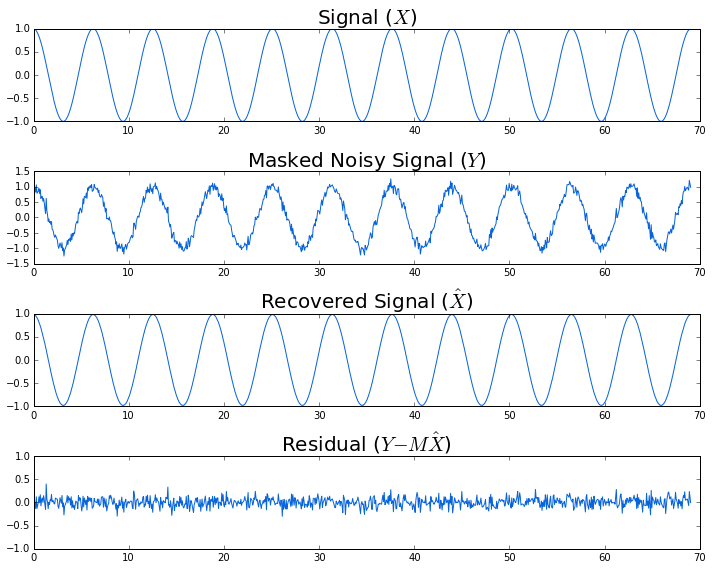

In [47]:
#############################
# NO NEED TO EDIT THIS CELL #
# JUST EXECUTE IT           #
#############################

# Display
if not isinstance(x_rec, type(None)):
    plt.subplot(411)
    plt.plot(t, x, color='#0764DB')
    plt.title('Signal ($X$)', fontsize=20)
    plt.subplot(412)
    plt.plot(t_mask, y, color='#0764DB')
    plt.title('Masked Noisy Signal ($Y$)', fontsize=20)
    plt.subplot(413)
    plt.plot(t, x_rec, color='#0764DB')
    plt.title('Recovered Signal ($\hat{X}$)', fontsize=20)
    plt.ylim(-1, 1)
    plt.subplot(414)
    plt.plot(t_mask, y - mask_op(x_rec, mask), color='#0764DB')
    plt.title('Residual ($Y-M\hat{X}$)', fontsize=20)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()

How well did you do?

## <font color='blue'>Hints</font>

---

** Exercise 1 Hints **

1. For your sparse representation you may want to use soemthing *fast and f(o)urious*.
1. Try not to get *mad* when estimating the noise.
1. Thresholding signals can be quite *hard*.
1. Make sure you theshold in the correct domain.
1. Make sure your recovered signal is the correct domain.

** Exercise 2 Hints **

1. Recall that $M$ is the masking operation and that $M^T$ is the upsampling. Both of these functions are already defined.
1. Note that both of these functions take the mask as a second argument.
1. Your intial estimate of $\alpha$ should be the same size as $X$.
1. Make sure your final recovered signal is in the correct domain.